In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras import losses
from keras import optimizers

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

import pickle

# VAE from base image to base image

## Autoencoder assembling

In [0]:
img_shape = (64, 64, 1)
batch_size = 16
latent_dim = 20

In [0]:
input_img = layers.Input(shape=img_shape)

x = layers.Conv2D(8, 3,
                  padding='same', activation='tanh')(input_img)
print(x.shape)

x = layers.Conv2D(16, 3,
                  padding='same', activation='tanh',
                  strides=(2, 2))(x)
print(x.shape)
x = layers.Conv2D(32, 3,
                  padding='same', activation='tanh',
                  strides=(2, 2))(x)

print(x.shape)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

(?, 64, 64, 8)
(?, 32, 32, 16)
(?, 16, 16, 32)


In [0]:
shape_before_flattening

(None, 16, 16, 32)

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), 
                            mean=0., stddev=.5)
    return z_mean + K.exp(z_log_var) * epsilon
  

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='tanh')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x) 


x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)


x = layers.Conv2D(64, 3, padding='same', activation='tanh')(x)

x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)

x = layers.Conv2D(1, 3, padding='same',
                  activation='tanh')(x) 

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded): 
        x = K.flatten(x) 
        z_decoded = K.flatten(z_decoded) 
        xent_loss = keras.metrics.mean_squared_error(x, z_decoded) 
        kl_loss = -5e-4 * K.mean( 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return xent_loss + kl_loss 
      
    def call(self, inputs): 
        x = inputs[0] 
        z_decoded = inputs[1] 
        loss = self.vae_loss(x, z_decoded) 
        self.add_loss(loss, inputs=inputs) 
        return x 
      
y = CustomVariationalLayer()([input_img, z_decoded])

In [0]:
vae = Model(input_img, y)
vae.compile(optimizer='Adam', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 8)    80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   1168        conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 32)   4640        conv2d_7[0][0]                   
__________________________________________________________________________________________________
flatten_2 

## Model learning

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/VAE/Lapteva_faults_10k.pickle', 'rb') as file:
    dataset = pickle.load(file)
    
    X_set = np.expand_dims(dataset['X_set'], axis=3)
    y_set = np.expand_dims(dataset['y_set'], axis=3)
    title = dataset['fault_title']
    del dataset 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set,
                                                    test_size=.2,
                                                    shuffle=True, random_state=17)

In [0]:
epochs = 30

history = vae.fit(x=X_train, y=None,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, None))

Train on 8192 samples, validate on 2048 samples
Epoch 1/30
8192/8192 [==============================] - 10s 1ms/step - loss: 0.0370 - val_loss: 0.0351
Epoch 2/30
8192/8192 [==============================] - 8s 969us/step - loss: 0.0347 - val_loss: 0.0348
Epoch 3/30
8192/8192 [==============================] - 8s 958us/step - loss: 0.0346 - val_loss: 0.0347
Epoch 4/30
8192/8192 [==============================] - 8s 974us/step - loss: 0.0344 - val_loss: 0.0344
Epoch 5/30
8192/8192 [==============================] - 8s 971us/step - loss: 0.0338 - val_loss: 0.0339
Epoch 6/30
8192/8192 [==============================] - 8s 969us/step - loss: 0.0331 - val_loss: 0.0332
Epoch 7/30
8192/8192 [==============================] - 8s 969us/step - loss: 0.0326 - val_loss: 0.0330
Epoch 8/30
8192/8192 [==============================] - 8s 968us/step - loss: 0.0321 - val_loss: 0.0327
Epoch 9/30
8192/8192 [==============================] - 8s 972us/step - loss: 0.0318 - val_loss: 0.0325
Epoch 10/30
8192/

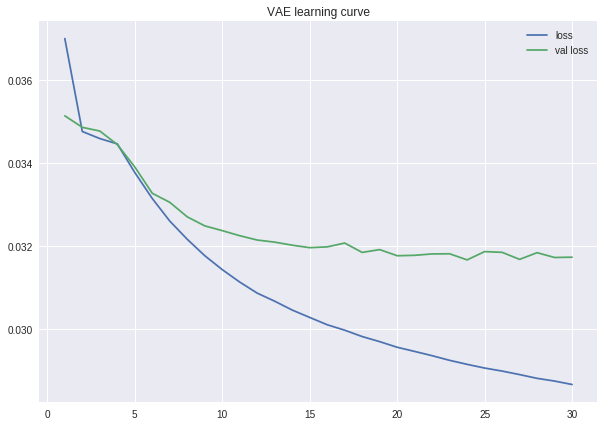

In [0]:
data = history.history
loss_ = np.max(data['loss'], axis=1)
val_loss_ = np.max(data['val_loss'], axis=1)
epochs_ = np.arange(1, epochs + 1, 1)

plt.figure(figsize=(10, 7))
plt.title('VAE learning curve')
plt.plot(epochs_, loss_, label='loss')
plt.plot(epochs_, val_loss_, label='val loss')
plt.legend();

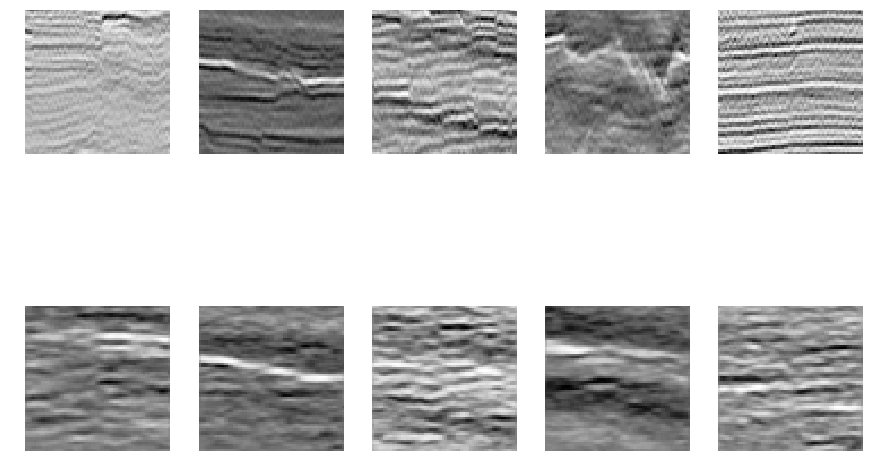

In [0]:
pred = np.squeeze(decoder.predict(encoder.predict(X_test[0:5])))
base = np.squeeze(X_test[0:5])

fig = plt.figure(figsize=(15, 10))

for i in range(1, 6):
    plt.subplot(2, 5, i)
    plt.imshow(base[i - 1])
    plt.axis('off')
    plt.grid(False)

for i in range(6, 11): 
    plt.subplot(2, 5, i)
    plt.imshow(pred[i - 6])
    plt.axis('off')
    plt.grid(False)
    
#plt.tight_layout()
